### Plano de Avalicação Dell Academy Trilha de Machine Learning

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn 
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer # módulo para fazer o Bag of words
import scipy.sparse
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from wordcloud import WordCloud
%matplotlib inline
import nltk
#nltk.download("all")
from nltk import tokenize
from string import punctuation

In [133]:
conda install -c conda-forge wordcloud

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


## Leitura do dataset de teste

In [134]:
df_test = pd.read_csv("datasets/test.csv")
df_test.head()

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg
3,"This is a terrible movie, and I'm not even sur...",neg
4,First of all this movie is a piece of reality ...,pos


## Leitura do dataset de treino

In [135]:
df_train = pd.read_csv("datasets/train.csv")
df_train.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


## Concatenando os datasets para otimizar a análise exploratória

In [136]:
df_unido = pd.concat([df_test, df_train], ignore_index=True)
df_unido.head()

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg
3,"This is a terrible movie, and I'm not even sur...",neg
4,First of all this movie is a piece of reality ...,pos


In [137]:
# Visão resumida do DF
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Visão geral do DF com Pandas Profilling

**Atualizando o pandas profiling**

In [138]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
#import sys

#!"{sys.executable}" -m pip install -U pandas-profiling[notebook]
#!jupyter nbextension enable --py widgetsnbextension

In [140]:
# Importando biblioteca Standart
from pathlib import Path

# Instalando pacotes
import pandas as pd
from ipywidgets import widgets

# Pacotes para trabalhar com o Profiling
from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file

In [141]:
# Gerando os relatórios do DF
profile = ProfileReport(
    df_unido, title="IMDB Dataset", html={"style": {"full_width": True}}, sort=None
)

In [142]:
# A interface de widgets do notebook
#profile.to_widgets()

In [143]:
# Usando o relatório em um HTML iframe 
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Análise**

Com o relatório acima podemos concluir que os dados estão balanceados...

**Adicionando a coluna (clf_num) para a classificação numérica dos sentimentos**

Legenda numérica para a coluna `clf_num`

Sentimento negativo = 0

Sentimento positivo = 1

In [144]:
# Armazenando na variável "classificacao" e substituindo os valores "neg" e "pos" da coluna sentiment pelos números 0 e 1 respectivamente
classificacao = df_unido["sentiment"]. replace(["neg", "pos"], [0,1])

In [145]:
# Adicionando a coluna "clf_num" ao dataframe chamando a variável "classificacao"
df_unido["clf_num"] = classificacao
df_unido.head()

,text,sentiment,clf_num
0,"My daughter liked it but I was aghast, that a ...",neg,0
1,I... No words. No words can describe this. I w...,neg,0
2,this film is basically a poor take on the old ...,neg,0
3,"This is a terrible movie, and I'm not even sur...",neg,0
4,First of all this movie is a piece of reality ...,pos,1


In [146]:
df_unido.dtypes

text         object
sentiment    object
clf_num       int64
dtype: object

In [147]:
# Soma dos valores NaN em relação as linhas (por isso o shape está setado em 0), multiplicado por 100
df_unido.isnull().sum()/df_unido.shape[0]*100

text         0.0
sentiment    0.0
clf_num      0.0
dtype: float64

# Tratando o texto

## Bag of words

**Vetorizando os dados de teste e treino**

In [148]:
vetorizador = CountVectorizer(max_features=10) # Pegando as 10 dimensões mais aparecem em cada linha do DF
bow = vetorizador.fit_transform(df_unido.text)
print(bow.shape) # Mostando o tamanho do vetor, foma da matriz

(50000, 10)


**Conclusão**

Cada resenha do corpus foi representada por um vetor de 10 dimensões

Após o processo de bag of words foi retornado uma matriz esparsa tamanho 2x2.

In [149]:
vetorizador.get_feature_names()  

['and', 'br', 'in', 'is', 'it', 'of', 'that', 'the', 'this', 'to']

In [150]:
# Visualizando o DF com o sparse DataFrame do sklearn. Ele irá interpretar e plotar a matriz 
matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(bow, columns=vetorizador.get_feature_names())

In [151]:
matriz_esparsa

,and,br,in,is,it,of,that,the,this,to
0,2,0,4,0,6,0,4,2,2,4
1,1,12,3,4,3,19,6,23,10,4
2,1,0,0,4,3,1,1,11,2,1
3,3,4,1,1,2,4,4,11,3,2
4,7,0,1,1,3,11,0,10,2,3
...,...,...,...,...,...,...,...,...,...,...
49995,2,0,1,3,0,0,0,0,2,0
49996,4,0,2,3,2,2,2,5,2,0
49997,19,8,12,16,8,16,20,29,15,15
49998,3,0,3,3,1,3,2,9,2,8


## Dividindo o DF em treino e teste

In [152]:
# Passando como parâmetro a coluna de classificão "clf_num" e o Bag of words
X_train, X_test, y_train, y_test = train_test_split(bow, df_unido.clf_num,random_state=50)

## Regressão Logística

In [153]:
regressao_logistica = LogisticRegression()
model = regressao_logistica.fit(X_train, y_train)
predicted = regressao_logistica.predict(X_test)
print("Regressão Logística:", model.score(X_test, y_test))

Regressão Logística: 0.60528


**Análise**

O modelo consegue obter uma taxa de acerto das predições de 60%

In [154]:
# Cálculo de todas as métricas
print("Acurácia:", model.score(X_test, y_test))
print("Kappa:", metrics.cohen_kappa_score(y_test, predicted))
print("Todas:", metrics.precision_recall_fscore_support(y_test, predicted))

Acurácia: 0.60528
Kappa: 0.21052507615568883
Todas: (array([0.60384736, 0.60678022]), array([0.61657617, 0.59394037]), array([0.61014539, 0.60029164]), array([6262, 6238], dtype=int64))


## Matriz de Confusão

In [155]:
# Definindo Matriz de Confusão
matriz_confusao = metrics.confusion_matrix(y_test, predicted)
print(matriz_confusao)

[[3861 2401]
 [2533 3705]]


Text(0.5, 1.0, 'Accuracy Score: 0.60528')

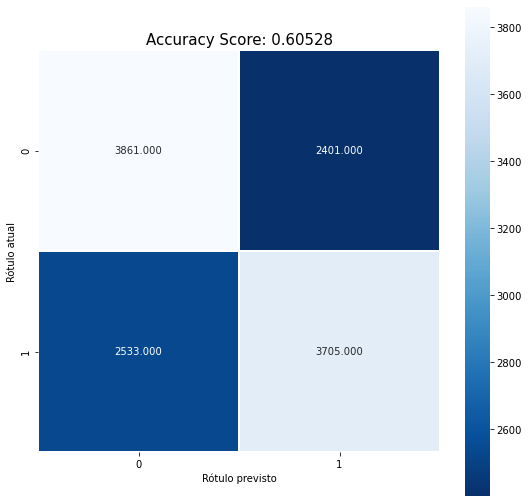

In [156]:
# Plotando Matriz de Confusão
plt.figure(figsize=(9,9))
sns.heatmap(matriz_confusao, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Rótulo atual');
plt.xlabel('Rótulo previsto');
all_sample_title = 'Accuracy Score: {0}'. format(model.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

**Análise**

As métricas acima foram calculadas basedas nas 10 dimensões mais frequentes em cada linha do DF, isto nos mostra que as palavras que mais aparecem neste recorte do DataFrame são conectivos (artigos, pronome demostrativo, preposições e parte de links) que não acrescentam neste momento de análise relevência semântica o que justifica o baixo valor de acuracácia e demais métricas. Portanto, é necessário realizar a retirada destas palavras através de técnicas de remoção de stopwords para que os valores sejam melhorados.

In [157]:
# Função para classificação do texto
# Onde: df_texto = df_unido, coluna_text = text, coluna_classificacao = clf_num do DF original

def classificacao_texto(df_texto, coluna_text, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bow = vetorizar.fit_transform(df_texto[coluna_text])
    
# Dividindo em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(bow, df_texto[coluna_classificacao],random_state=50)

# Regressão Logística
    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(X_train, y_train)
    return regressao_logistica.score(X_test, y_test)

# Chamada da função     
print(classificacao_texto(df_unido, "text", "clf_num"))

0.65072


In [158]:
# Utilizando listcomprehension para armazenar na variável "palavras" todas as frases do df_unido para mais adiante plotar a wordcloud
# O "join" foi utilizado para juntar as frases e separar por espaço
palavras = ' '.join([texto for texto in df_unido.text]) 
# Verificando o tamanho da lista
len(palavras)

65521550

## WordCLoud | Nuvem de Palavras

In [159]:
# Gerando a nuvem de palavras
word_cloud = WordCloud(width=800, height=500,
                      max_font_size=110,
                      collocations=False, # para calcular as palavras pela frequência
                      background_color="white",
                      ).generate(palavras)

**Plotando a imagem da nuvem de palavras**

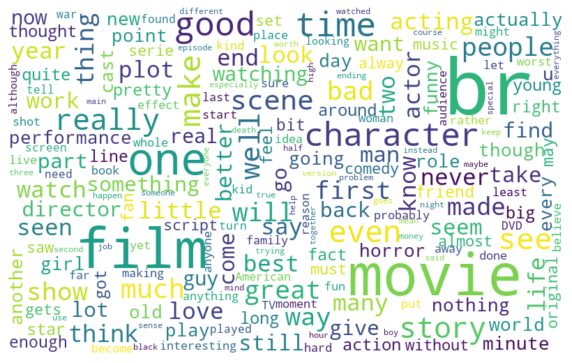

In [160]:
# Definindo o tamamnho da imagem
plt.figure(figsize=(10,7)) 
# O conteúdo da imagem é o que está armazenado na variável "word_cloud". 
# O parâmetro interpolation setado em 'bilinear' torna a visualização mais nítida
plt.imshow(word_cloud, interpolation='bilinear') 
# Removendo a numeraçao dos eixos x e y
plt.axis("off") 
# Exibindo a imagem
plt.show()

**Análise**

No primeiro momento observa-se que a palavra filme "`movie`" tem bastante relevância dentro do corpus, no entanto há muitas palavras que não nos dão muitas informações. Por isso, podemos como estratégia para melhorar a análise, plotar as wordclouds separadas pelos sentimentos negativos e positivos.

**Visualização da wordcloud para frases positivas e negativas**

In [161]:
# Consultando todas as sentenças classificadas com sentimento positivo :"pos", "1"
df_unido.query("sentiment == 'pos'")

,text,sentiment,clf_num
4,First of all this movie is a piece of reality ...,pos,1
8,If you want to see a film starring Stan laurel...,pos,1
11,Cocky medical students play chicken with proce...,pos,1
12,This movie is excellent in how it portrays the...,pos,1
14,So after years and years I finally track this ...,pos,1
...,...,...,...
49990,Spirit: Stallion of the Cimarron is an overall...,pos,1
49992,I've read a number of reviews on this film and...,pos,1
49993,"'Where the Sidewalk Ends (1950)' opens, approp...",pos,1
49995,"This film is fun, if your a person who likes a...",pos,1


In [162]:
# Consultando todas as sentenças classificadas com sentimento negativo :"neg", "0"
df_unido.query("sentiment == 'neg'")

,text,sentiment,clf_num
0,"My daughter liked it but I was aghast, that a ...",neg,0
1,I... No words. No words can describe this. I w...,neg,0
2,this film is basically a poor take on the old ...,neg,0
3,"This is a terrible movie, and I'm not even sur...",neg,0
5,"As a young lass, beautiful Joan Woodbury (as R...",neg,0
...,...,...,...
49991,Dynasty Revisited in Hawaii... Full of clichés...,neg,0
49994,"""The Bubble"" is an effort to make a gay Romeo ...",neg,0
49997,first this deserves about 5 stars due to actin...,neg,0
49998,If you like films that ramble with little plot...,neg,0


## Função para gerar as nuvens de palavras separadas por sentimento negativo e positivo 

In [163]:
# Função que irá retornar somente os sentimentos negativos para em seguida ser plotado na wordcloud
def nuvem_negativa(df_texto, coluna_text):
    texto_negativo = df_texto.query("sentiment == 'neg'")
    palavras = ' '.join([texto for texto in texto_negativo[coluna_text]]) 


    # Gerando a nuvem de palavras
    word_cloud = WordCloud(width=800, height=500,
                          max_font_size=110,
                          collocations=False,  # Collocations setado como False para calcular as palavras pela frequência
                          background_color="white").generate(palavras)
    
    # Plotando a imagem
    plt.figure(figsize=(10,7)) 
    plt.imshow(word_cloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.show()    

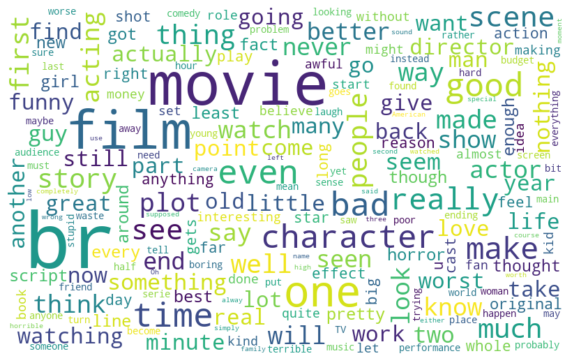

In [164]:
# Plotanto somente os sentimentos negativos da coluna "text"
nuvem_negativa(df_unido, "text")

**Análises**


Observa-se ...

In [165]:
# Função que irá retornar somente os sentimentos positivos para em seguida ser plotado na wordcloud
def nuvem_positiva(df_texto, coluna_text):
    texto_positivo = df_texto.query("sentiment == 'pos'")
    palavras = ' '.join([texto for texto in texto_positivo[coluna_text]]) 


    # Gerando a nuvem de palavras
    word_cloud = WordCloud(width=800, height=500,
                          max_font_size=110,
                          collocations=False, # Collocations setado como False para calcular as palavras pela frequência
                          background_color="white").generate(palavras)
    
    # Plotando a imagem
    plt.figure(figsize=(10,7)) 
    plt.imshow(word_cloud, interpolation='bilinear') 
    plt.axis("off") # "axis" setado como "off" para não aparecer os números na wordcloud
    plt.show()    

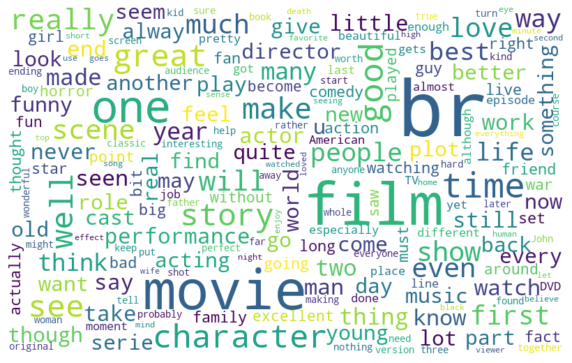

In [166]:
# Plotanto somente os sentimentos positivos da coluna "text"
nuvem_positiva(df_unido, "text")

**Análises**


Observa-se...

# Trabalhando com NLTK 

### TOKENIZAÇÃO

Calculando a frequência de cada palavras atavés da técnica de *`tokenização`*

In [215]:
# Tokenização de todo o corpus (separação por palavras) 
token_espaco = tokenize.WhitespaceTokenizer()
token_df = token_espaco.tokenize(palavras) # variável "palavras" armazenda todas as frases do meu corpus

In [216]:
# Calculando a frequência
freq_palavras = nltk.FreqDist(token_df)
freq_palavras

FreqDist({'the': 568735, 'a': 306960, 'and': 301919, 'of': 283625, 'to': 261850, 'is': 203056, 'in': 169981, 'I': 132498, 'that': 126818, 'this': 113726, ...})

In [171]:
# Criando um DF para armazenar as palavras e suas frequências de ocorrência no corpus para melhorar a visualização
df_freq = pd.DataFrame({"palavra": list(freq_palavras.keys()),
                       "frequencia": list(freq_palavras.values())})

In [172]:
# Chamando o DataFrame com a frequência das palavras
df_freq.head()

,palavra,frequencia
0,My,2973
1,daughter,1377
2,liked,2800
3,it,107916
4,but,66282


In [173]:
# Mostrando as 10 palavras com maior frequência utilizando o método "nlargest"
df_freq.nlargest(columns = "frequencia", n = 10)

,palavra,frequencia
46,the,568735
9,a,306960
59,and,301919
71,of,283625
20,to,261850
89,is,203056
11,in,169981
5,I,132498
8,that,126818
12,this,113726


**Análise**

Ao impirmir as palavras com maior frequência no DataFrame constata-se que são palavras de classe gramatical (artigo, conjunção, preposição, verbo, pronome pessoal e pronome demonstrativo) que em sua maioria não possuem relevância semântica suficiente que justifique sua permanência no copus de análise. Portanto, deve-se proceder com a remoção através da técnica de remoção de stopwors.

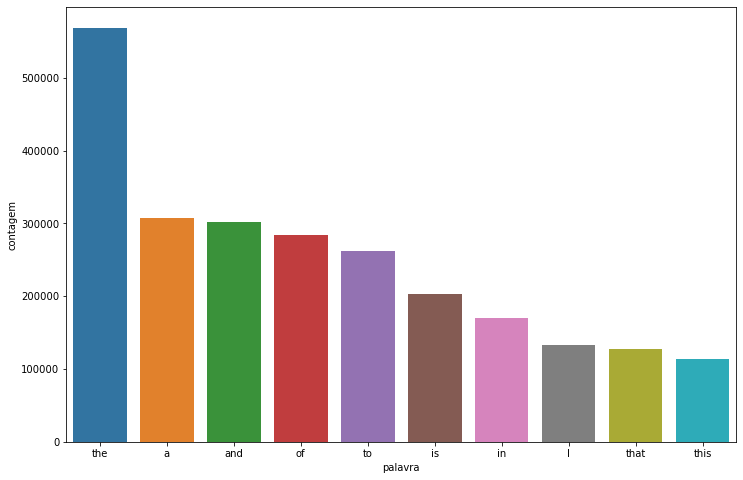

In [286]:
def histograma(df_texto, coluna_text, quantidade):
     
    palavras = ' '.join([texto for texto in df_texto[coluna_text]])     
    token_df = token_espaco.tokenize(palavras)
    freq_palavras = nltk.FreqDist(token_df)
    df_freq = pd.DataFrame({"palavra": list(freq_palavras.keys()),
                       "frequencia": list(freq_palavras.values())})
   
    df_freq = df_freq.nlargest(columns = "frequencia", n = quantidade)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_freq, x = "palavra", y = "frequencia")
    ax.set(ylabel = "contagem")
    plt.show()
               

histograma(df_unido, "text", 10)

## Removendo Stopwords

In [231]:
df_unido.head()

,text,sentiment,clf_num
0,"My daughter liked it but I was aghast, that a ...",neg,0
1,I... No words. No words can describe this. I w...,neg,0
2,this film is basically a poor take on the old ...,neg,0
3,"This is a terrible movie, and I'm not even sur...",neg,0
4,First of all this movie is a piece of reality ...,pos,1


In [269]:
# Armazenando na variável "stopwords" a lista de stopwords do corpus do inglês
stopwords = nltk.corpus.stopwords.words("english")

# Armazena a frase tokenizada (que foi processada), em uma lista
frase_processada = list()

# Retiranto as stopwords de cada frase/linha da coluna "text" do DataFrame 
for resenha in df_unido.text:
    frase_nova = list()
    palavra_texto = token_espaco.tokenize(resenha)
    for palavra in palavra_texto:
        if palavra not in stopwords:
            frase_nova.append(palavra)
            
    frase_processada.append(' '. join(frase_nova)) # Juntando todas as frases
    
# Criando uma coluna com a frase processada, isto é, após a remoção das stopwords
df_unido["processamento_1"] = frase_processada    

In [271]:
df_unido.head()

,text,sentiment,clf_num,processamento_1,processamento_2
0,"My daughter liked it but I was aghast, that a ...",neg,0,"My daughter liked I aghast, character movie sm...","My daughter liked I aghast, character movie sm..."
1,I... No words. No words can describe this. I w...,neg,0,I... No words. No words describe this. I try s...,I... No words. No words describe this. I try s...
2,this film is basically a poor take on the old ...,neg,0,film basically poor take old urban legend baby...,film basically poor take old urban legend baby...
3,"This is a terrible movie, and I'm not even sur...",neg,0,"This terrible movie, I'm even sure terrible. I...","This terrible movie, I'm even sure terrible. I..."
4,First of all this movie is a piece of reality ...,pos,1,First movie piece reality well realized artist...,First movie piece reality well realized artist...


In [240]:
# Aplicando a função 'classificacao_texto' na coluna "processamento_1" utilizando como base a coluna da classificação dos sentimentos 'clf_num' 
classificacao_texto(df_unido, "processamento_1", "clf_num")

0.71352

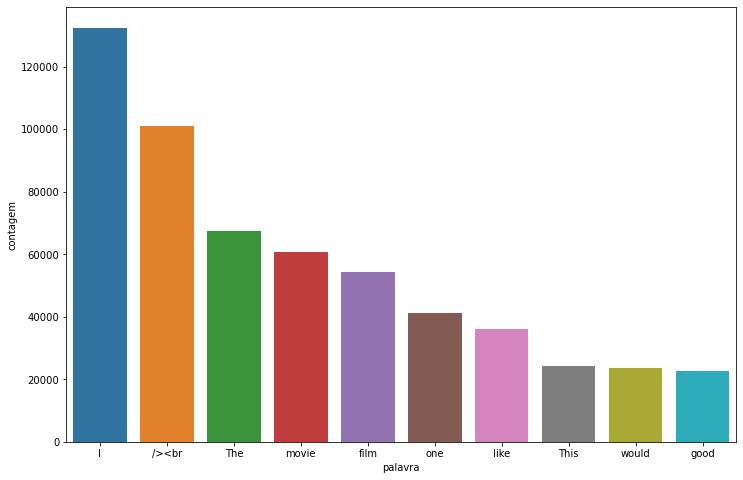

In [241]:
# Histograma - Plotando as palavras mais frequentes após a remoção das stopwords
histograma(df_unido, "processamento_1", 10)

**Análise**

Após a remoção das stopwords e passando para a função "`classificacao_texto`" como parâmetro a coluna "`processamento_1`" que contém as frases processadas/tratadas, podemos fazer um comparativo dos resultados obtidos na primeira classificação com esta última. Observamos que a primeira (Regressão Logística) obteve a acurácia de `0.65072` e a segunda o valor de `0.71352`, um aumento de `0,0628` no total de acerto. Estes resultados poderão ser melhorados conforme avançamos no tratamento do corpus, esta foi somente a primeira parte. 

## Removendo as pontuações das palavras do dataset

In [250]:
# Pontuações que serão removidas do corpus 
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [278]:
# Inserindo as pontuações em uma lista cada um sendo separado como elemento único
pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)
    
# Inserindo a pontuação na lista de stopwords
pontuacao_stopwords = pontuacao + stopwords

# Iterando sobre a lista (texto) que já passou pelo primeiro tratamento e que está armazenado na coluna "processamento_1" 
frase_processada2 = list()
for resenha in df_unido["processamento_1"]:
    frase_nova2 = list()
    palavras_texto2 = token_pontuacao.tokenize(resenha)
    for palavra in palavras_texto2:
        if palavra not in pontuacao_stopwords:
            frase_nova2.append(palavra)
    frase_processada2.append(' '.join(frase_nova2))
            
df_unido["processamento_2"] = frase_processada2

In [280]:
# Analisando se a remoção das stopwords funcionou
df_unido.head()

,text,sentiment,clf_num,processamento_1,processamento_2
0,"My daughter liked it but I was aghast, that a ...",neg,0,"My daughter liked I aghast, character movie sm...",My daughter liked I aghast character movie smo...
1,I... No words. No words can describe this. I w...,neg,0,I... No words. No words describe this. I try s...,I ... No words No words describe I try sake br...
2,this film is basically a poor take on the old ...,neg,0,film basically poor take old urban legend baby...,film basically poor take old urban legend baby...
3,"This is a terrible movie, and I'm not even sur...",neg,0,"This terrible movie, I'm even sure terrible. I...",This terrible movie I even sure terrible It ug...
4,First of all this movie is a piece of reality ...,pos,1,First movie piece reality well realized artist...,First movie piece reality well realized artist...


**Comparando a remoção das pontuações na linha de índice "0" das colunas "processamento_1 e processamento_2"**

In [281]:
df_unido["processamento_1"][0]

'My daughter liked I aghast, character movie smokes. As awful enough see "product placement" actors like Bruce Willis smoke movies - least children movies considerate! I wonder: intentional? Did big tobacco "sponsor" film? What take ban smoking films? At least films intended children adolescents. My daughter liked I aghast, character movie smokes. As awful enough see "product placement" actors like Bruce Willis smoke movies - least children movies considerate! I wonder: intentional? Did big tobacco "sponsor" film? What take ban smoking films? At least films intended children adolescents.'

In [282]:
df_unido["processamento_2"][0]

'My daughter liked I aghast character movie smokes As awful enough see product placement actors like Bruce Willis smoke movies least children movies considerate I wonder intentional Did big tobacco sponsor film What take ban smoking films At least films intended children adolescents My daughter liked I aghast character movie smokes As awful enough see product placement actors like Bruce Willis smoke movies least children movies considerate I wonder intentional Did big tobacco sponsor film What take ban smoking films At least films intended children adolescents'

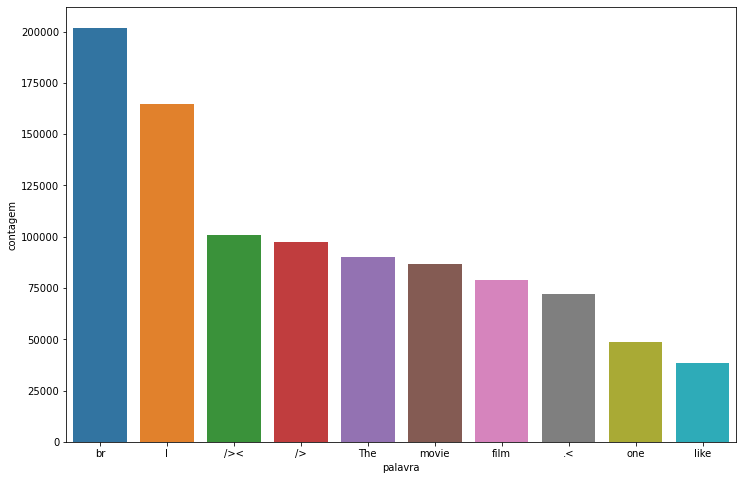

In [283]:
histograma(df_unido, "processamento_2", 10)

In [284]:
# Aplicando a função 'classificacao_texto' na coluna "processamento_2" utilizando como base a coluna da classificação dos sentimentos 'clf_num' 
classificacao_texto(df_unido, "processamento_2", "clf_num")

0.71288

**Análise**

Podemos observar no gráfico acima que após o processso de remoção das pontuações não houve uma mudança significativa no cálculo da acurácia, pelo contrário, houve uma leve redução nesse valor indo de `0.71352` para `0.71288`. 

Observando as posições das 10 palavras mais frequentes do dataset percebemos que a palavra `"I"` saiu da primeira posição na ordem de maior frequência cedendo espaço para `"br"` que vinha logo em seguida. Já a palavra `"like"` passou da sétima posição para a décima do histograma em ordem de maior frequência.

## Normalização de textos 

Removendo acentos das palavras